***
# TEST
***

In [ ]:
import os
import json
import pandas as pd
import pvdeg
from pytest import approx
from pvdeg import TEST_DATA_DIR

#Load weather data
WEATHER = pd.read_csv(os.path.join(TEST_DATA_DIR, 'weather_day_pytest.csv'),
                         index_col= 0, parse_dates=True)
with open(os.path.join(TEST_DATA_DIR, 'meta.json'),'r') as file:
    META = json.load(file)

#Load expected results
rh_expected = pd.read_csv(os.path.join(TEST_DATA_DIR, 'input_day_pytest.csv'),
                          index_col=0, parse_dates=True)
rh_cols = [col for col in rh_expected.columns if 'RH' in col]
rh_expected = rh_expected[rh_cols]


def test_module():
    '''
    test pvdeg.humidity.calc_rel_humidity
    
    Requires:
    ---------
    weather dataframe and meta dictionary
    '''
    result = pvdeg.humidity.module(WEATHER, META)
    pd.testing.assert_frame_equal(result, 
                                  rh_expected, 
                                  check_dtype=False)

def test_psat():
    '''
    test pvdeg.humidity.psat
    
    Requires:
    ---------
    weahter dataframe and meta dictionary
    '''
    psat_avg = pvdeg.humidity.psat(temp=WEATHER['temp_air'])[1]
    assert psat_avg == approx(0.47607, abs=5e-5)



In [ ]:
test_psat()

In [ ]:
import pvdeg
from pvdeg import TEST_DATA_DIR
import os
import pandas as pd

In [ ]:
sample_df = pd.read_csv(os.path.join(TEST_DATA_DIR, "diffusion_2d_input.csv"), index_col=0)

sample_df.index = pd.to_timedelta(sample_df.index)
sample_df.index = sample_df.index.values.astype("timedelta64[s]")

In [ ]:
res = pvdeg.diffusion.module_front(
    time_index=sample_df.index,
    backsheet_moisture=sample_df["Back Encapsulant Moisture"],
    sample_temperature=sample_df["Sample Temperature"],
    p=0.1,
    CW=15.6,
    nodes=20,
    eva_diffusivity_ea=0.395292897,
    Dif=2.31097881676966,
    n_steps=20,
)

In [1]:
import pandas as pd
import numpy as np
import pvdeg
from pvdeg import TEST_DATA_DIR
import os

In [2]:
setpoints = pd.read_csv(os.path.join(TEST_DATA_DIR, "chamber-setpoints.csv"), skiprows=[1])

In [3]:
test_chamber = pvdeg.chamber.Chamber(os.path.join(TEST_DATA_DIR, "chamber-setpoints.csv"), setpoint_names=["temperature", "relative_humidity"], skiprows=[1])

test_chamber.setpoints = test_chamber.setpoints.iloc[:100]

Test Chamber Conditions

In [4]:
chamber_result = test_chamber.chamber_conditions(tau_c=10, air_temp_0=25).iloc[:100]

chamber_result.to_csv("chamber_conditions_result.csv")

In [5]:
CHAMBER_CONDITIONS = pd.read_csv("chamber_conditions_result.csv", index_col=0)
CHAMBER_CONDITIONS.index = CHAMBER_CONDITIONS.index.astype("timedelta64[s]")

pd.testing.assert_frame_equal(chamber_result, CHAMBER_CONDITIONS, check_dtype=False)

Test sample conditions

In [6]:
test_chamber.setBacksheet(id='ST504', thickness=0.5) # PET
test_chamber.setEncapsulant(id='EVA', thickness=0.1) # EVA
sample_result = test_chamber.sample_conditions(tau_s=15, sample_temp_0=25, n_steps=20)

In [7]:
sample_result.to_csv("sample_conditions_results.csv")

In [8]:
SAMPLE_CONDITIONS = pd.read_csv(os.path.join(TEST_DATA_DIR, "sample_conditions_results.csv"), index_col=0)
SAMPLE_CONDITIONS.index = SAMPLE_CONDITIONS.index.astype("timedelta64[s]")

pd.testing.assert_frame_equal(sample_result, SAMPLE_CONDITIONS)

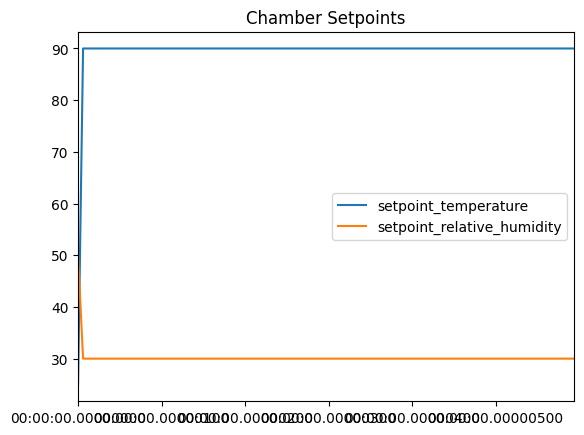

In [9]:
test_chamber.plot_setpoints()

In [10]:
test_chamber.calc_temperatures(air_temp_0=25, sample_temp_0=25, tau_c=10, tau_s=15)

pd.testing.assert_series_equal(test_chamber.air_temperature, CHAMBER_CONDITIONS["Air Temperature"], check_dtype=False)
pd.testing.assert_series_equal(test_chamber.sample_temperature, SAMPLE_CONDITIONS["Sample Temperature"], check_dtype=False)

In [11]:
SAMPLE_CONDITIONS

,Sample Temperature,Sample Relative Humidity,Equilibrium Encapsulant Water,Back Encapsulant Moisture,Relative Humidity Internal Cells Backside
0 days 00:00:00,25.000000,50.000000,0.000096,0.000096,50.000000
0 days 00:01:00,25.398926,42.402850,0.000083,0.000096,49.072137
0 days 00:02:00,26.133087,55.724432,0.000112,0.000096,47.608766
0 days 00:03:00,27.146513,68.971168,0.000145,0.000096,45.793053
0 days 00:04:00,28.390111,81.256339,0.000181,0.000097,43.778688
...,...,...,...,...,...
0 days 01:35:00,89.674148,30.361616,0.000595,0.000400,20.439282
0 days 01:36:00,89.694879,30.338632,0.000595,0.000402,20.533853
0 days 01:37:00,89.714300,30.317102,0.000595,0.000405,20.627901
0 days 01:38:00,89.732493,30.296934,0.000594,0.000407,20.721406


In [12]:
bad_df = pd.DataFrame(np.nan, index=pd.RangeIndex(5), columns=["Temperature"])

In [13]:
pvdeg.chamber.setpoint_series(df=bad_df, setpoint_name="Temperature")

ValueError: column: Temperature contains NaN values. Remove from setpoint list or remove NaN's in input.

In [15]:
import pytest
with pytest.raises(ValueError) as excinfo:
    pvdeg.chamber.setpoint_series(df=bad_df, setpoint_name="Temperature")

# Check that the exception message is correct
assert str(excinfo.value) == "column: Temperature contains NaN values. Remove from setpoint list or remove NaN's in input."